<b>Limitations of Basic GAN </b>: mode collapse, not a good coorelation between the loss value and the quality of the generator, and problem with flat gradients in BCE loss.

#### Wasserstein Loss: 
It helps with mode collapse and vanishing gradient issues





In [1]:
import os,torch,torchvision,PIL
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
'''Visualize'''
def show(tensor, num = 25):
    data = tensor.detach().to('cpu')
    grid = make_grid(data[:num], nrow = 5).permute(1,2,0)
    plt.imshow(grid.clip(0,1))
    plt.show()

'''Hyper-parameters'''
n_epochs = 1000
batch_size = 128
lr = 1e-4
z_dim = 200

cur_step = 0
# To avoid critic being overpowered by the generator; critic is trained for 5 cycles for every one cycle of generator training
crit_cycles = 5

gen_losses = []
crit_losses = []
show_step = 35
save_step = 35       # checkpoint save every 35 step

In [3]:
# Generator

class Generator(nn.Module):
    def __init__(self, z_dim, d_dim = 16):
        super(Generator, self).__init__()
        self.z_dim = z_dim 
        # nn.ConvTranspose2d(): used in generator ----> 1x1 noise vector with a number of channels to a full sized image [ (n-1)*stride - 2*padding + kernel_size ]
        # in convTranspose2d we begin with a 1x1 image with z_dim channels (200). We increase the size of image gradually with a decrease in the number of channels.

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(in_channels = z_dim, out_channels = d_dim*32 , kernel_size = 4, stride = 1, padding = 0), # 1x1 image 200 channel to 4x4 image 512 channels
            nn.BatchNorm2d(num_features = d_dim*32),
            nn.ReLU(inplace = True),

            nn.ConvTranspose2d(in_channels = d_dim*32, out_channels = d_dim*16, kernel_size = 4, stride = 2, padding = 1), # 4x4 image 512 channel to 8x8 image 256 channels
            nn.BatchNorm2d(num_features = d_dim*16),
            nn.ReLU(inplace = True),

            nn.ConvTranspose2d(in_channels = d_dim*16, out_channels = d_dim*8, kernel_size = 4, stride = 2, padding = 1), # 16x16 image with 128 channels 
            nn.BatchNorm2d(num_features = d_dim*8),
            nn.ReLU(inplace = True),

            nn.ConvTranspose2d(in_channels = d_dim*8, out_channels = d_dim*4, kernel_size = 4, stride = 2, padding = 1), # 32x32 image with 64 channels 
            nn.BatchNorm2d(num_features = d_dim*4),
            nn.ReLU(inplace = True),

            nn.ConvTranspose2d(in_channels = d_dim*4, out_channels = d_dim*2, kernel_size = 4, stride = 2, padding = 1), # 64x64 image with 32 channels 
            nn.BatchNorm2d(num_features = d_dim*2),
            nn.ReLU(inplace = True),

            nn.ConvTranspose2d(in_channels = d_dim*2, out_channels = 3, kernel_size = 4, stride = 2, padding = 1), # 128x128 image with 3 channels 
            nn.Tanh() # squeeze outputs in region -1 to +1 which is suitable for WGAN

        )
    
    def forward(self, noise):
        x = noise.view(-1, self.z_dim, 1, 1)        # output: 128 x 200 x 1 x 1 i.e. batch x channels x 1 x 1
        return self.gen(x)
    
    def gen_noise(self,num, z_dim, device):
        return torch.randn(num, z_dim, device = device) # 128 x 200

In [4]:
# Critic
class Critic(nn.Module):
    def __init__(self, d_dim = 16):
        super(Critic, self).__init__()
        # nn.conv2d: Used in critic ---> full image to prediction
        # new width and height: (n+2*padding - kernel_Size) // stride + 1  where 'n' is previous height and width of image. We're working with image size 128x128
        self.critic = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = d_dim, kernel_size = 4, stride = 2, padding = 1),   # 64x64 image & channels = 16
            nn.InstanceNorm2d(d_dim), # It has been found that normalizing by instance works well in Critic model
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels = d_dim, out_channels = d_dim*2, kernel_size = 4, stride = 2, padding = 1),   # 32x32 image & channels = 32
            nn.InstanceNorm2d(d_dim*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels = d_dim*2, out_channels = d_dim*4, kernel_size = 4, stride = 2, padding = 1),   # 16x16 image & channels = 64
            nn.InstanceNorm2d(d_dim*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels = d_dim*4, out_channels = d_dim*8, kernel_size = 4, stride = 2, padding = 1),   # 8x8 image & channels = 128
            nn.InstanceNorm2d(d_dim*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels = d_dim*8, out_channels = d_dim*16, kernel_size = 4, stride = 2, padding = 1),   # 4x4 image & channels = 256
            nn.InstanceNorm2d(d_dim*16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels = d_dim*16, out_channels = 1, kernel_size = 4, stride = 1, padding = 0),   # 1x1 image & channels = 1  (final prediction) 
        )
    
    def forward(self,image):
        # image: batch x channel x height x width
        predict = self.critic(image)  # 128 x 1 x 1 x 1
        return predict.view(len(predict), -1)

In [5]:
'''Dataset, DataLoader, Declare... '''

class Dataset(Dataset):
    def __init__(self, path, size = 128, lim = 10):
        self.sizes = [size, size]
        items, labels = [], []

        for data in os.listdir(path)[:lim]:
            # path = './img_align_celeba'
            # data = 002000.jpg (for example)
            item = os.path.join(path, data)
            items.append(item)
            labels.append(data)
        
        self.items = items
        self.labels = labels

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        # transform = transforms.Compose([transforms.Resize(self.sizes)])
        # data = transform(data).to(device)
        data = Image.open(self.items[index]).convert('RGB')  # PIL Image
        data = np.asarray(transforms.Resize(self.sizes)(data))    # 128 x 128 x 3
        data = torch.from_numpy(data).div(255).permute(2,0,1) # values from 0 to 1 and shape 3 x 128 x 128
        return data, self.labels[index]

# Dataset
path = './img_align_celeba/'
dataset = Dataset(path, size = batch_size, lim = 10)

# DataLoader
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

# Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr, betas = (0.5,0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr = lr, betas = (0.5,0.9))

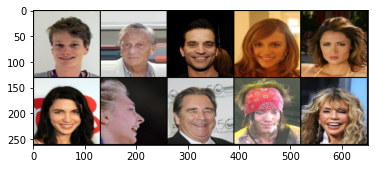

In [6]:
x,y = next(iter(dataloader))
show(x)

In [7]:
# Gradient Penalty

def get_gp(real, fake, crit, alpha, gamma = 10):
    x = alpha*real + (1-alpha)*fake # linear interpolation between a real and a fake image: batch_size x channels x height x width
    y = crit(x) # 128 x 1
    # gradient = dy/dx computes gradient of output w.r.t input
    gradient = torch.autograd.grad(
        inputs = x,
        outputs = y,
        grad_outputs = torch.ones_like(y),
        retain_graph = True,
        create_graph = True
    )[0]  # 128 x 3 x 128 x 128

    gradient = gradient.view(len(gradient),-1)
    gradient_norm = gradient.norm(p = 2, dim =1)  # p-norm = 2 along horizontal dimension of 1
    gradient_penalty = gamma*((gradient_norm-1)**2).mean()  # we calcuate the mean because we're trying to get the expected value
    
    return gradient_penalty

In [8]:
# Save and Load Checkpoint

root_path = './data/'

def save_checkpoint(name):
    if not os.path.exists(root_path):
        os.makedirs(root_path)
    torch.save({
        'Epoch': epoch,
        'Model_State_Dict': gen.state_dict(),
        'Optimizer_state_dict': gen_opt.state_dict(),
        'Loss': loss_gen
        }, f'{root_path}Generator-{name}.pkl')

    torch.save({
        'Epoch': epoch,
        'Model_State_Dict': crit.state_dict(),
        'Optimizer_state_dict': crit_opt.state_dict(),
        'Loss': loss_critic
        }, f'{root_path}Critic-{name}.pkl')
    
    print ('Checkpoint Saved')

def load_checkpoint(name):
    checkpoint = torch.load(f'{root_path}Generator-{name}.pkl')
    gen.load_state_dict(checkpoint['Model_State_Dict'])
    gen_opt.load_state_dict(checkpoint['Optimizer_state_dict'])
    epoch = checkpoint['Epoch']
    loss_gen = checkpoint['Loss']

    checkpoint = torch.load(f'{root_path}Critic-{name}.pkl')
    crit.load_state_dict(checkpoint['Model_State_Dict'])
    crit_opt.load_state_dict(checkpoint['Optimizer_state_dict'])
    epoch = checkpoint['Epoch']
    loss_crit = checkpoint['Loss']

    print ('Checkpoint Loaded with the following parameters:')
    print ('Epoch:{} Generator Loss: {:.4f} Critic Loss: {:.4f}'.format(epoch,loss_gen,loss_crit))
    

Saving Checkpoint with the following parameters:
Epoch: 35 Generator Loss: 16.6754 Critic Loss: -21.4378
Checkpoint Saved


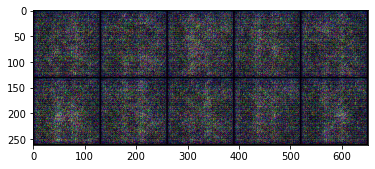

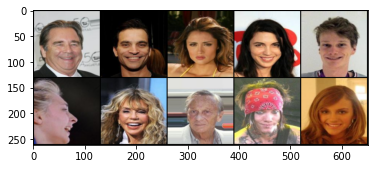

Epoch: 35 Generator Loss: 10.5362 Critic Loss: -11.9556


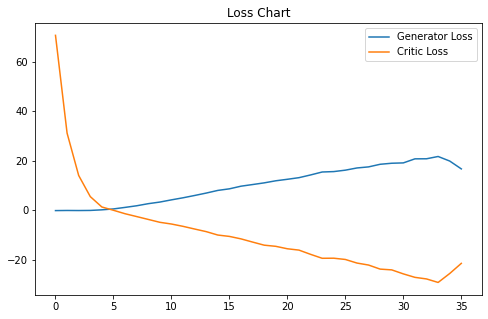

Saving Checkpoint with the following parameters:
Epoch: 70 Generator Loss: 20.1384 Critic Loss: -34.8585
Checkpoint Saved


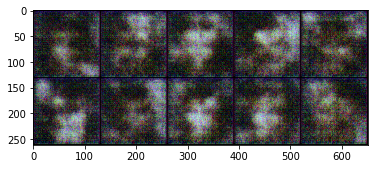

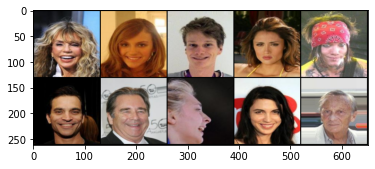

Epoch: 70 Generator Loss: 19.9365 Critic Loss: -30.4594


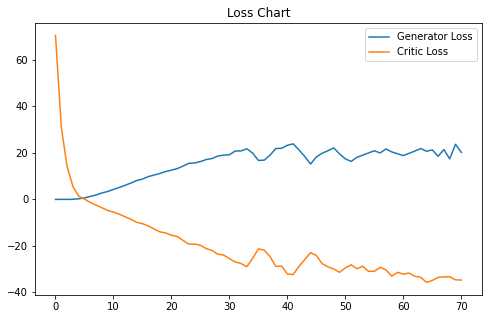

Saving Checkpoint with the following parameters:
Epoch: 105 Generator Loss: 28.6153 Critic Loss: -46.7686
Checkpoint Saved


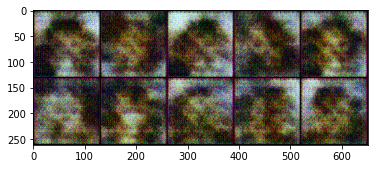

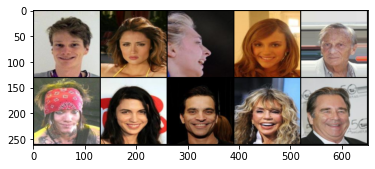

Epoch: 105 Generator Loss: 26.0033 Critic Loss: -41.4673


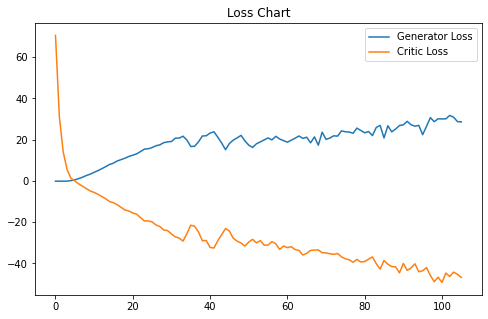

Saving Checkpoint with the following parameters:
Epoch: 140 Generator Loss: 28.9731 Critic Loss: -45.2867
Checkpoint Saved


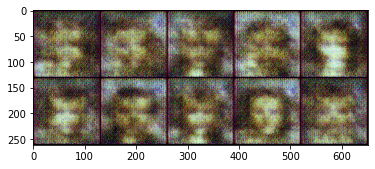

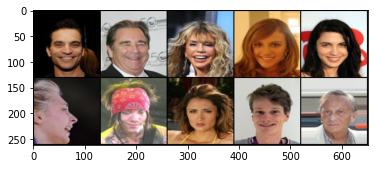

Epoch: 140 Generator Loss: 28.9542 Critic Loss: -46.2455


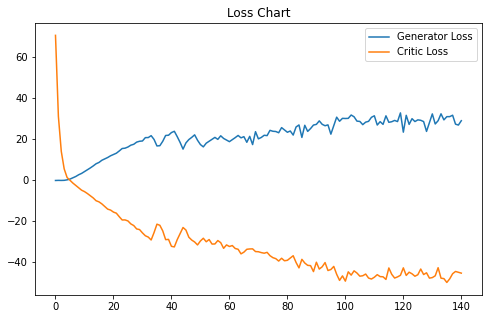

Saving Checkpoint with the following parameters:
Epoch: 175 Generator Loss: 26.8295 Critic Loss: -43.5407
Checkpoint Saved


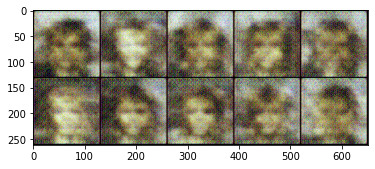

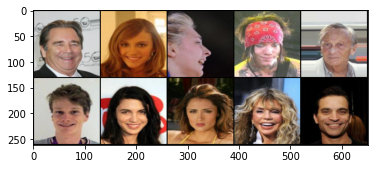

Epoch: 175 Generator Loss: 27.4830 Critic Loss: -44.5553


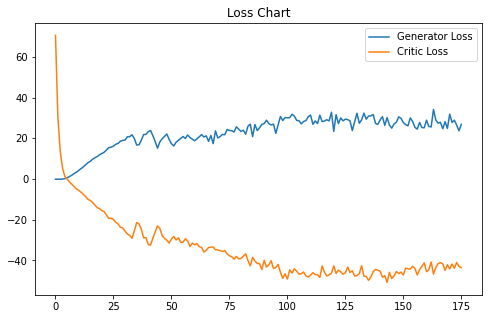

In [9]:
# Training Loop

for epoch in range(n_epochs):
    for real, _ in dataloader:
        cur_bs = len(real) # current batch size
        real = real.to(device)

        # Critic
        loss_critic = 0
        for _ in range(crit_cycles):
            crit_opt.zero_grad()
            noise = gen.gen_noise(cur_bs, z_dim, device = device)
            fake = gen.forward(noise)
            crit_fake_pred = crit.forward(fake.detach())
            crit_real_pred = crit.forward(real)

            # We need to get the gradient penalty before computing the loss
            alpha = torch.rand(cur_bs,1,1,1, device = device, requires_grad = True)  # 128 random numbers form a uniform distribution betwwen 0 and 1
            gp = get_gp(real, fake.detach(), crit, alpha)

            cr_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

            loss_critic += cr_loss.item() / crit_cycles

            cr_loss.backward(retain_graph = True)
            crit_opt.step()
            
        crit_losses += [loss_critic]
        
        # Generator
        gen_opt.zero_grad()
        noise = gen.gen_noise(cur_bs,z_dim, device = device)
        fake = gen.forward(noise)
        crit_fake_pred = crit.forward(fake)

        loss_gen = -crit_fake_pred.mean()
        loss_gen.backward(retain_graph = True)
        gen_opt.step()

        gen_losses += [loss_gen.item()]

        # Save Checkpoint
        if (cur_step % save_step == 0 and cur_step > 0):
            print ('Saving Checkpoint with the following parameters:')
            print ('Epoch: {} Generator Loss: {:.4f} Critic Loss: {:.4f}'.format(epoch, loss_gen, loss_critic))
            save_checkpoint('latest') # Overrides

        # Status
        if (cur_step % show_step == 0 and cur_step > 0):
            show(fake)
            show(real)

            gen_mean = sum(gen_losses[-show_step:]) / show_step
            crit_mean = sum(crit_losses[-show_step:]) / show_step
            print('Epoch: {} Generator Loss: {:.4f} Critic Loss: {:.4f}'.format(epoch, gen_mean, crit_mean))

            plt.figure(figsize=(8,5))
            plt.plot(range(len(gen_losses)), torch.Tensor(gen_losses), label = 'Generator Loss')
            plt.plot(range(len(crit_losses)), torch.Tensor(crit_losses), label = 'Critic Loss')
            plt.title('Loss Chart')
            plt.legend()
            #plt.ylim(-100,100)
            plt.show(block = True)
        cur_step+=1     

    # breaking training loop...don't want whole training process in this notebook
    if epoch == 175:
        break   